In [1]:
import torch
import torchvision
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

### GPU Selection

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

### Configure Path

In [3]:
NUM_CLASS = 2
LABEL_MAP = {'AR': 0, 'Non_AR': 1}
EPOCHS = 10
PATH_TO_DATASET = "/home/mirap/0_DATABASE/1_sperm_acrosome_reaction/2_AR_1000/voc/"

In [4]:
# If you want to adjust num_workers, then check avaliable CPU cores.
# setting num_workers to the maximum number of available CPUs is not always the best approach, 
# as it may result in degraded performance due to overhead and contention for resources.
import psutil

cpu_count = psutil.cpu_count()
cpu_percent = psutil.cpu_percent()

cpu_available = cpu_count - int(cpu_count * (cpu_percent/100))
print("Max num_workers for this system: ", cpu_count)
print("Number of available CPU cores:", cpu_available)

Max num_workers for this system:  96
Number of available CPU cores: 93


## Functions for Dataset loader

In [9]:
# Define the transformations to apply to the images "1/255 scale"
transform = torchvision.transforms.Compose([
    torchvision.transforms.Pad((0, 400)), # Pad the height with 400 pixels
    torchvision.transforms.ToTensor()
])

# Define the target transform function
def target_transform(target):
    # Extract the labels from the target
    for obj in target['annotation']['object']:
        obj['name'] = LABEL_MAP[obj['name']]
    
    return target

In [10]:
# Load the Pascal VOC dataset
voc_dataset = torchvision.datasets.VOCDetection(PATH_TO_DATASET, 
                                                  year='2008', 
                                                  image_set='trainval', 
                                                  download=False, 
                                                  transform=transform,
                                                  target_transform=target_transform)

# Get an example image and annotation from the dataset
image, target = voc_dataset[0]

# Report data sizes
print('Training set has {} instances'.format(len(voc_dataset)))
# print('Validation set has {} instances'.format(len(validation_set)))

Training set has 93 instances


In [13]:
data_loader = torch.utils.data.DataLoader(voc_dataset,
                                          batch_size=1,
                                          shuffle=False,
                                          num_workers=4)

## Check loaded Data

torch.Size([3, 1600, 1200])


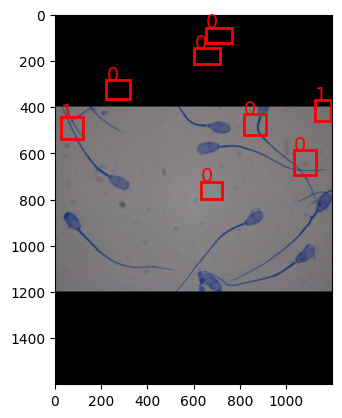

In [14]:
# Get one sample from the data_loader
data_iter = iter(data_loader)
images, targets = next(data_iter)

# Get the first image in the batch
image = images[0]


# Plot the image and target
fig, ax = plt.subplots()
ax.imshow(image.permute(1, 2, 0))

# Loop through each object in the target and plot its bounding box and label
for obj in target['annotation']['object']:
    # Get the class label for the object
    cls = obj['name']
    
    # Get the bounding box coordinates for the object
    xmin = int(obj['bndbox']['xmin'])
    ymin = int(obj['bndbox']['ymin'])
    xmax = int(obj['bndbox']['xmax'])
    ymax = int(obj['bndbox']['ymax'])
    
    # Draw the bounding box and label on the image
    ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                fill=False, edgecolor='red', linewidth=2))
    ax.text(xmin, ymin, f'{cls}', fontsize=14, color='red')
    
# Show the image and target
print(image.shape)
plt.show()

## Set GPU environment

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## Define Model

In [ ]:
import torchvision.models.detection as torch_det
detection_model = torch_det.ssd300_vgg16(num_classes=NUM_CLASS)

In [ ]:
import torch.nn as nn

def object_detection_model():
    model = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(480000, 1024),
        nn.BatchNorm1d(1024),
        nn.ReLU(),
        nn.Linear(1024, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Linear(512, NUM_CLASS+1),
        nn.Softmax(dim=1)
    )

    return model

detection_model = object_detection_model()

In [ ]:
with torch.no_grad(): # Mute the output
    detection_model.to(device)

In [ ]:
import torch.optim as optim
# define your loss function
loss_fn = nn.CrossEntropyLoss()

# define your optimizer
optimizer = optim.SGD(detection_model.parameters(), lr=0.001, momentum=0.9)

def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(data_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = detection_model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(data_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [ ]:
import torchvision.models.detection as torch_det
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter

# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

best_vloss = 1_000_000.
# detection_model.to("cpu")
for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    detection_model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    detection_model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(data_loader):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

In [ ]:
# saved_model = GarmentClassifier()
# saved_model.load_state_dict(torch.load(PATH))
# https://pytorch.org/tutorials/beginner/introyt/trainingyt.html